In [2]:
#import libraries
import matplotlib.pyplot as plt
%matplotlib inline
import math
import collections
import numpy as np
import scipy.optimize as opt
import pandas as pd
from mpl_toolkits.mplot3d import axes3d

In [3]:
def satellitecentre(data, pos,N_min,alpha,reps_max=1e3):
    ##################################################
    ##Find the center of the satellite (highest density peak)
    ##by itereatively decreasing sphere around particles and finding the
    ##center of mass within the sphere
    #########
    ##INPUT##
    #########
    #data: numpy array, Nx7... contains particle ID,x,y,z,vx,vy,vz
    #pos: numpy array, Nx3... contains positions for each particle, x,y,z
    #N_min: minimum number of particles within sphere before exiting iteration
    #alpha: factor to decrease sphere size by... at each iteration R = alpha*R
    #reps_max: maximum number of iterations before exiting... in case of infinite while loop
    #########
    ##OUTPUT
    #########
    #COM: numpy array of length 3... gives center of satellite halo
    ##################################################

    N = data.shape[0]

    #First estimate: center of mass
    COM = np.array([np.mean(pos[:,0]), np.mean(pos[:,1]), np.mean(pos[:,2])])
    p = pos-COM
    r = np.sqrt(pos[:,0]*pos[:,0] + pos[:,1]*pos[:,1] + pos[:,2]*pos[:,2])
    R = max(r) #size of sphere around particles
    N = data.shape[0]

    #Itereatively find center
    reps = 0
    while (N>N_min):
        COM += [np.mean(p[:,0]), np.mean(p[:,1]), np.mean(p[:,2])]
        R = alpha*R #decrease size of sphere
        p = pos-COM
        r = np.sqrt(p[:,0]*p[:,0] + p[:,1]*p[:,1] + p[:,2]*p[:,2])
        p = p[r<R]
        N  = p.shape[0]
        reps+=1
        if reps==reps_max:
            print("clustercentre didn't converge")
            break

    return COM



In [4]:
def remove_unbound(data,G,m,r_max=np.inf,P0=0.0):
    ##################################################
    ##Removes particles with binding energy less than P0
    ##Make sure data is in the frame of the satellite
    ##Assumes spherical potential
    #########
    ##INPUT##
    #########
    #data: numpy array, Nx7... contains particle ID,x,y,z,vx,vy,vz
    #G: Gravitational constant
    #m: mass of each particle
    #r_max: only include particles within this radius (default infinity)
    #P0: minimum energy of bound particles (default 0)
    #########
    ##OUTPUT
    #########
    #data_bound: N_boundx7... numpy array containing unbound particles
    ##################################################
    data_bound = 1.0*data
    nnew = data.shape[0]
    nold = nnew + 1

    while nold>nnew:
        #print(nold,nnew)
        r = np.sqrt(data_bound[:,1]**2 +  data_bound[:,2]**2 +  data_bound[:,3]**2)
        data_bound = data_bound[r<r_max]
        E = energies_spherical(data_bound,G,m,P0)
        data_bound = data_bound[E>0]
        nold = int(nnew)
        nnew = data_bound.shape[0]

    return data_bound

In [5]:
def potential_spherical(r,G,m):
    #########################################################
    ##Calculates the potential of an N-body system, assuming its's spherical
    #########################################################
    #########
    ##INPUT##
    #########
    #r: numpy array of length N... radial distance of each particle
    #G: gravitational constant
    #m: mass of each particle
    #########
    ##OUTPUT##
    #########
    #P: potential at position of each particle
    #########################################################
    r[r==0]+=1e-6 #make sure no zeros.

    #Inside Potential
    R_sort, R_ind = np.unique(r, return_inverse=True) #sorted list without repeats, index
    par_int = (np.cumsum(np.concatenate(([0], np.bincount(R_ind)))))[R_ind] #number of interior particles
    P = par_int/r
    #Outside Potential
    counter = collections.Counter(r) # find repeated values
    vals = counter.values() #number of repeats of value in keys
    keys = counter.keys()
    vals = np.array(list(vals), dtype=float) #Convert to arrays
    keys = np.array(list(keys), dtype=float)
    inds = keys.argsort() # increasing order of keys
    reps = vals[inds] #get number of repeats in increasing order
    R_out = reps[::-1] * 1/R_sort[::-1]
    R_out = np.cumsum(R_out) - R_out #sum 1/R for all exterior particles
    R_out = R_out[::-1] #flip direction
    P += R_out[R_ind]

    P = -G*m*P
    return P

In [6]:
def energies_spherical(data,G,m,P=0.0,P0=0.0):
    ##################################################
    ##Calculate the energy of each particle
    ##assumes spherical potential if P not specified
    #########
    ##INPUT##
    #########
    #data: numpy array, Nx7... contains particle ID,x,y,z,vx,vy,vz
    #G: Gravitational constant
    #m: mass of each particle
    #P: can pass the potential of each particle if it is precalculated...
    #   otherwise it will calculate the potential assuming sphericity
    #P0: in case the energy should be shifted by a constant P
    #########
    ##INPUT##
    #########
    #E: Energy of each each particle... energy is defined as in Binney and Tremaine as
    #   E=-(P+K)... negative energies mean the particle is unbound
    ##################################################
    r = np.sqrt(data[:,1]**2 +  data[:,2]**2 +  data[:,3]**2)
    v = np.sqrt(data[:,4]**2 +  data[:,5]**2 +  data[:,6]**2)

    if isinstance(P,float) or isinstance(P,int):
        P = potential_spherical(r,G,m)
    E=(-P-P0) - v*v/2.0

    return E

In [59]:
halo = np.loadtxt("000circ500.txt", skiprows=7)

halo2 = np.loadtxt("250circ500.txt", skiprows=7)

halo3 = np.loadtxt("500circ500.txt", skiprows=7)

halo4 = np.loadtxt("750circ500.txt", skiprows=7)

halo5 = np.loadtxt("1104circ500.txt", skiprows=7)

IC = np.loadtxt("10e5.txt", skiprows=1)

In [60]:
center = satellitecentre(halo,halo[:,1:4] ,100,.9, 1e3)
center2 = satellitecentre(halo2,halo2[:,1:4] ,100,.9, 1e3)
center3 = satellitecentre(halo3,halo3[:,1:4] ,100,.9, 1e3)
center4 = satellitecentre(halo4,halo4[:,1:4] ,100,.9, 1e3)
center5 = satellitecentre(halo5,halo5[:,1:4] ,100,.9, 1e3)

In [61]:
# halo3[:,1] - center[0]

# halo3[:,2] - center[1]

# halo3[:,3] - center[2]

halo[:,1] = halo[:,1] - center[0]

halo[:,2] = halo[:,2] - center[1]

halo[:,3] = halo[:,3] - center[2]




halo2[:,1] = halo2[:,1] - center2[0]

halo2[:,2] = halo2[:,2] - center2[1]

halo2[:,3] = halo2[:,3] - center2[2]




halo3[:,1] = halo3[:,1] - center3[0]

halo3[:,2] = halo3[:,2] - center3[1]

halo3[:,3] = halo3[:,3] - center3[2]


halo4[:,1] = halo4[:,1] - center4[0]

halo4[:,2] = halo4[:,2] - center4[1]

halo4[:,3] = halo4[:,3] - center4[2]


halo5[:,1] = halo5[:,1] - center5[0]

halo5[:,2] = halo5[:,2] - center5[1]

halo5[:,3] = halo5[:,3] - center5[2]



# rad = np.sqrt(halo3[:,1]**2 + halo3[:,2]**2 + halo3[:,3]**2)

rad = np.sqrt(halo[:,1]**2 + halo[:,2]**2 + halo[:,3]**2)

rad2 = np.sqrt(halo2[:,1]**2 + halo2[:,2]**2 + halo2[:,3]**2)

rad3 = np.sqrt(halo3[:,1]**2 + halo3[:,2]**2 + halo3[:,3]**2)

rad4 = np.sqrt(halo4[:,1]**2 + halo4[:,2]**2 + halo4[:,3]**2)

rad5 = np.sqrt(halo5[:,1]**2 + halo5[:,2]**2 + halo5[:,3]**2)

In [62]:
# vx = halo3[:,4]
# vy = halo3[:,5]
# vz = halo3[:,6]

vx = halo[:,4]
vy = halo[:,5]
vz = halo[:,6]

vxavg = np.average(vx[rad<100])
vyavg = np.average(vy[rad<100])
vzavg = np.average(vz[rad<100])

velocityframe = []
velocityframe.append(vxavg)
velocityframe.append(vyavg)
velocityframe.append(vzavg)




vx2 = halo2[:,4]
vy2 = halo2[:,5]
vz2 = halo2[:,6]

vxavg2 = np.average(vx2[rad2<100])
vyavg2 = np.average(vy2[rad2<100])
vzavg2 = np.average(vz2[rad2<100])

velocityframe2 = []
velocityframe2.append(vxavg2)
velocityframe2.append(vyavg2)
velocityframe2.append(vzavg2)



vx3 = halo3[:,4]
vy3 = halo3[:,5]
vz3 = halo3[:,6]

vxavg3 = np.average(vx3[rad3<100])
vyavg3 = np.average(vy3[rad3<100])
vzavg3 = np.average(vz3[rad3<100])

velocityframe3 = []
velocityframe3.append(vxavg3)
velocityframe3.append(vyavg3)
velocityframe3.append(vzavg3)



vx4 = halo4[:,4]
vy4 = halo4[:,5]
vz4 = halo4[:,6]

vxavg4 = np.average(vx4[rad4<100])
vyavg4 = np.average(vy4[rad4<100])
vzavg4 = np.average(vz4[rad4<100])

velocityframe4 = []
velocityframe4.append(vxavg4)
velocityframe4.append(vyavg4)
velocityframe4.append(vzavg4)



vx5 = halo5[:,4]
vy5 = halo5[:,5]
vz5 = halo5[:,6]

vxavg5 = np.average(vx5[rad5<100])
vyavg5 = np.average(vy5[rad5<100])
vzavg5 = np.average(vz5[rad5<100])

velocityframe5 = []
velocityframe5.append(vxavg5)
velocityframe5.append(vyavg5)
velocityframe5.append(vzavg5)

In [63]:
# halo3[:,4] = halo3[:,4] - velocityframe[0]
# halo3[:,5] = halo3[:,5] - velocityframe[1]
# halo3[:,6] = halo3[:,6] - velocityframe[2]

halo[:,4] = halo[:,4] - velocityframe[0]
halo[:,5] = halo[:,5] - velocityframe[1]
halo[:,6] = halo[:,6] - velocityframe[2]

halo2[:,4] = halo2[:,4] - velocityframe2[0]
halo2[:,5] = halo2[:,5] - velocityframe2[1]
halo2[:,6] = halo2[:,6] - velocityframe2[2]


halo3[:,4] = halo3[:,4] - velocityframe3[0]
halo3[:,5] = halo3[:,5] - velocityframe3[1]
halo3[:,6] = halo3[:,6] - velocityframe3[2]

halo4[:,4] = halo4[:,4] - velocityframe4[0]
halo4[:,5] = halo4[:,5] - velocityframe4[1]
halo4[:,6] = halo4[:,6] - velocityframe4[2]



halo5[:,4] = halo5[:,4] - velocityframe5[0]
halo5[:,5] = halo5[:,5] - velocityframe5[1]
halo5[:,6] = halo5[:,6] - velocityframe5[2]



# halo3[:,4] = halo3[:,4] - averagevelocity
# halo3[:,5] = halo3[:,5] - averagevelocity
# halo3[:,6] = halo3[:,6] - averagevelocity

In [64]:
un = remove_unbound(halo,1,1e-5)
un2 = remove_unbound(halo2,1,1e-5)
un3 = remove_unbound(halo3,1,1e-5)
un4 = remove_unbound(halo4,1,1e-5)
un5 = remove_unbound(halo5,1,1e-5)

rad = np.sqrt(un[:,1]**2 + un[:,2]**2 + un[:,3]**2)
rad2 = np.sqrt(un2[:,1]**2 + un2[:,2]**2 + un2[:,3]**2)
rad3 = np.sqrt(un3[:,1]**2 + un3[:,2]**2 + un3[:,3]**2)
rad4 = np.sqrt(un4[:,1]**2 + un4[:,2]**2 + un4[:,3]**2)
rad5 = np.sqrt(un5[:,1]**2 + un5[:,2]**2 + un5[:,3]**2)

In [65]:
nn = np.histogram(rad, bins=np.logspace(-2,2,50))
nn2 = np.histogram(rad2, bins=np.logspace(-2,2,50))
nn3 = np.histogram(rad3, bins=np.logspace(-2,2,50))
nn4 = np.histogram(rad4, bins=np.logspace(-2,2,50))
nn5 = np.histogram(rad5, bins=np.logspace(-2,2,50))

mass = np.array(nn[0]) * 1e-5
mass2 = np.array(nn2[0]) * 1e-5
mass3 = np.array(nn3[0]) * 1e-5
mass4 = np.array(nn4[0]) * 1e-5
mass5 = np.array(nn5[0]) * 1e-5

In [66]:
volume11 = []

for i in range(len(nn[0])):
    volume11.append((4/3) * np.pi * ((nn[1][i+1]**3)-(nn[1][i]**3)))
volume11 = np.array(volume11)


density = mass/volume11


volume2 = []

for i in range(len(nn2[0])):
    volume2.append((4/3) * np.pi * ((nn2[1][i+1]**3)-(nn2[1][i]**3)))
volume2 = np.array(volume2)


density2 = mass2/volume2



volume3 = []

for i in range(len(nn3[0])):
    volume3.append((4/3) * np.pi * ((nn3[1][i+1]**3)-(nn3[1][i]**3)))
volume3 = np.array(volume3)


density3 = mass3/volume3


volume4 = []

for i in range(len(nn4[0])):
    volume4.append((4/3) * np.pi * ((nn4[1][i+1]**3)-(nn4[1][i]**3)))
volume4 = np.array(volume4)


density4 = mass4/volume4


volume5 = []

for i in range(len(nn5[0])):
    volume5.append((4/3) * np.pi * ((nn5[1][i+1]**3)-(nn5[1][i]**3)))
volume5 = np.array(volume5)


density5 = mass5/volume5

In [67]:
density = np.append(density,0)
density2 = np.append(density2,0)
density3 = np.append(density3,0)
density4 = np.append(density4,0)
density5 = np.append(density5,0)

In [68]:
#Original Density Profile


ic10e5t = np.loadtxt("snapshot10e5t.txt")
particleNumber = ic10e5t[:,0]
x = ic10e5t[:,1]
y = ic10e5t[:,2]
z = ic10e5t[:,3]

rad1 = np.sqrt(x**2 + y**2 + z**2)

number_particles1 = np.histogram(rad1, bins=np.logspace(-2,2,50))

mass1 = np.array(number_particles1[0]) * 1e-5

volume1 = []

for i in range(len(mass1)):
    volume1.append((4/3) * np.pi * ((number_particles1[1][i+1]**3)-(number_particles1[1][i]**3)))
volume1 = np.array(volume1)

density1= mass1/volume1

density1 = np.append(density1, 0)



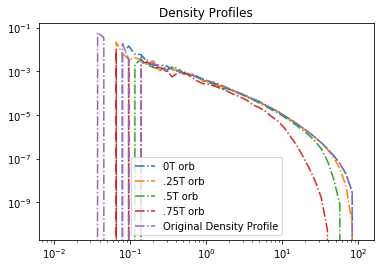

In [70]:
plt.plot(number_particles1[1], density1, "-.",label="Original Density Profile")
plt.plot(nn[1], density, "-.",label="0T orb")
plt.plot(nn2[1], density2, "-.",label=".25T orb")
plt.plot(nn3[1], density3, "-.",label=".5T orb")
plt.plot(nn4[1], density4, "-.",label=".75T orb")
# plt.plot(nn5[1], density5, "-.",label="Torb")
# plt.plot(nnn[1], ndensity, "-.", label="ss")
plt.title("Density Profiles")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.savefig("DensityProfiles.png")

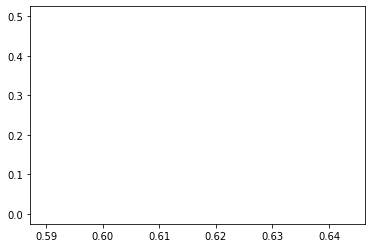

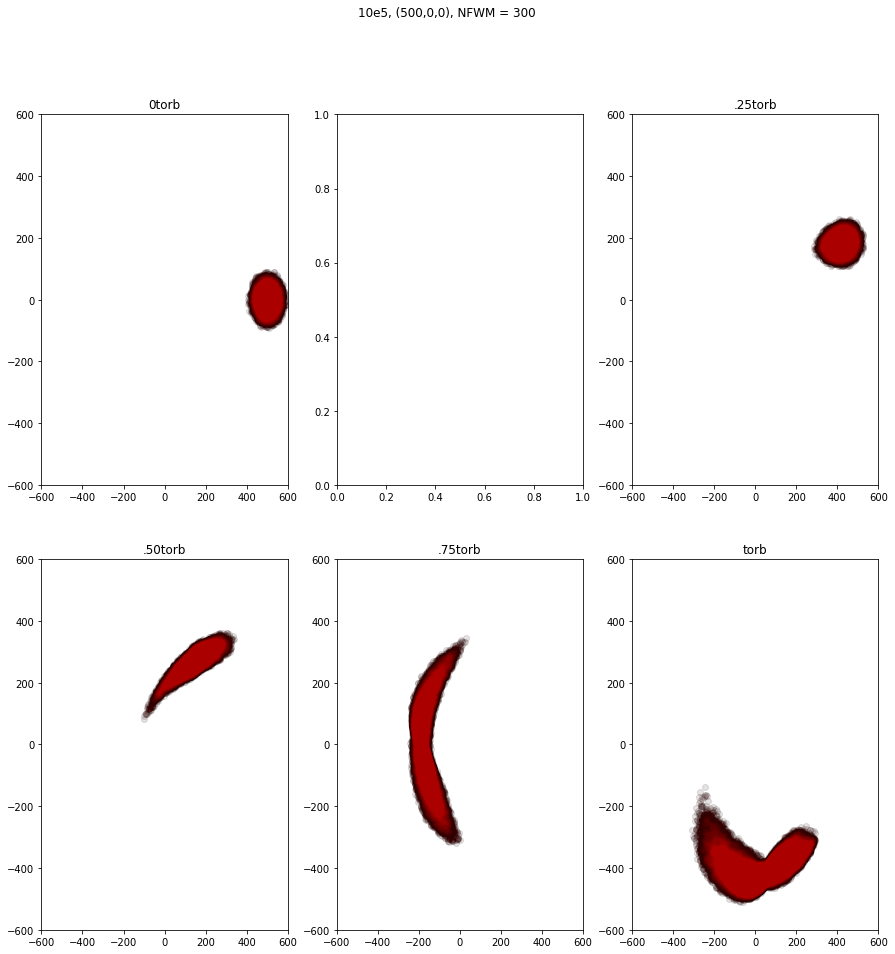

In [102]:
#Plotting the points
ICLnfw = np.loadtxt("000circ500.txt",skiprows=7)
particleNumber = ICLnfw[:,0]
X = ICLnfw[:,1]
Y = ICLnfw[:,2]
Z = ICLnfw[:,3]

ICLnfw2 = remove_unbound(ICLnfw,1,1)
particleNumber2 = ICLnfw2[:,0]
X2 = ICLnfw2[:,1]
Y2 = ICLnfw2[:,2]
Z2 = ICLnfw2[:,3]


ICLnfw3 = np.loadtxt("250circ500.txt",skiprows=7)
particleNumber3 = ICLnfw3[:,0]
X3 = ICLnfw3[:,1]
Y3 = ICLnfw3[:,2]
Z3 = ICLnfw3[:,3]

ICLnfw4 = remove_unbound(ICLnfw3,1,1)
particleNumber4 = ICLnfw4[:,0]
X4 = ICLnfw4[:,1]
Y4 = ICLnfw4[:,2]
Z4 = ICLnfw4[:,3]

ICLnfw5 = np.loadtxt("500circ500.txt",skiprows=7)
particleNumber5 = ICLnfw5[:,0]
X5 = ICLnfw5[:,1]
Y5 = ICLnfw5[:,2]
Z5 = ICLnfw5[:,3]

ICLnfw6 = remove_unbound(ICLnfw5,1,1)
particleNumber6 = ICLnfw6[:,0]
X6 = ICLnfw6[:,1]
Y6 = ICLnfw6[:,2]
Z6 = ICLnfw6[:,3]

ICLnfw7 = np.loadtxt("750circ500.txt",skiprows=7)
particleNumber7 = ICLnfw7[:,0]
X7 = ICLnfw7[:,1]
Y7 = ICLnfw7[:,2]
Z7 = ICLnfw7[:,3]

ICLnfw8 = remove_unbound(ICLnfw7,1,1)
X8 = ICLnfw8[:,1]
Y8 = ICLnfw8[:,2]
Z8 = ICLnfw8[:,3]

ICLnfw9 = np.loadtxt("1104circ500.txt",skiprows=7)
X9 = ICLnfw9[:,1]
Y9 = ICLnfw9[:,2]
Z9 = ICLnfw9[:,3]

ICLnfw10 = remove_unbound(ICLnfw9,1,1)
X10 = ICLnfw10[:,1]
Y10 = ICLnfw10[:,2]
Z10 = ICLnfw10[:,3]

fig, axs = plt.subplots(2,3,figsize=(15,15))
axs[0,0].scatter(X, Y, c='Black', alpha=0.1)
axs[0,0].scatter(X2,Y2,c="red",alpha=0.01)
axs[0,0].set_title("0torb")
axs[0,0].set_xlim(-600,600)
axs[0,0].set_ylim(-600,600)


# axs[0,1].scatter(X2, Y2, c='Black', alpha=0.01)
# axs[0,1].set_title("time 40")
# axs[0,1].set_xlim(-600,600)
# axs[0,1].set_ylim(-600,600)


axs[0,2].scatter(X3, Y3, c='Black', alpha=0.1)
axs[0,2].scatter(X4, Y4, c='Red', alpha=0.01)
axs[0,2].set_title(".25torb")
axs[0,2].set_xlim(-600,600)
axs[0,2].set_ylim(-600,600)


axs[1,0].scatter(X5, Y5, c='Black', alpha=0.1)
axs[1,0].scatter(X6, Y6, c='Red', alpha=0.01)
axs[1,0].set_title(".50torb")
axs[1,0].set_xlim(-600,600)
axs[1,0].set_ylim(-600,600)


axs[1,1].scatter(X7, Y7, c='Black', alpha=0.1)
axs[1,1].scatter(X8, Y8, c='Red', alpha=0.01)
axs[1,1].set_title(".75torb")
axs[1,1].set_xlim(-600,600)
axs[1,1].set_ylim(-600,600)


axs[1,2].scatter(X9, Y9, c='Black', alpha=0.1)
axs[1,2].scatter(X10, Y10, c='red', alpha=0.01)
axs[1,2].set_title("torb")
axs[1,2].set_xlim(-600,600)
axs[1,2].set_ylim(-600,600)



fig.suptitle('10e5, (500,0,0), NFWM = 300')
plt.show()
fig.savefig("10e5,(500,0,0).png")